# Paths, Routes, and Transitions

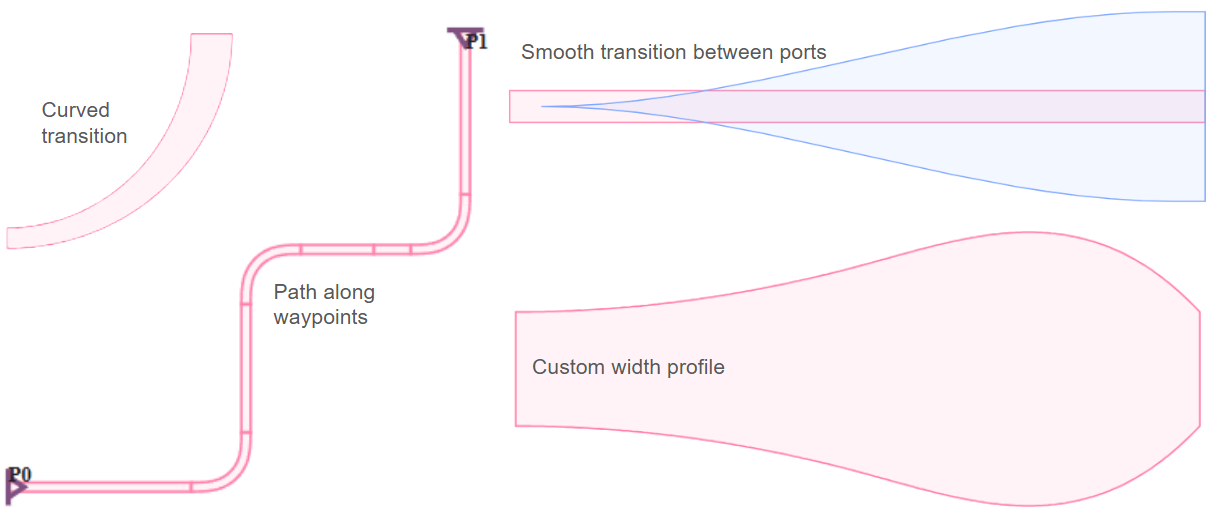

This notebook showcases the layout capabilities of PhotonForge for designing and manipulating photonic structures using paths. We cover how to define paths with varying widths and offsets, route between ports with or without waypoints, apply smooth transitions between different waveguide types, and generate envelopes and offset layers for fabrication. These tools provide a versatile foundation for creating complex photonic layouts with clarity and control.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()
pf.config.default_technology = pf.basic_technology()

Starting live viewer at http://localhost:5001


## Creating a Path 

We begin by creating a [Path](../_autosummary/photonforge.Path.rst) object. This structure allows us to define photonic waveguides, routes and even more complex structures. First, we add a straight segment, followed by an arc using the `euler_fraction` parameter to create a smooth curvature. Note that the arc angle is defined with respect to the **y-axis** in the **clockwise** direction.


In [2]:
# Create a new Path object starting at origin (0, 0) with initial width 0.5
p = pf.Path(origin=(0, 0), width=0.5)

# Add a straight segment ending at (0, 5) with constant width 0.5
p.segment(endpoint=(0, 5), width=0.5)

# Add a 45-degree arc (clockwise from y-axis), using Euler curvature smoothing
p.arc(initial_angle=0, final_angle=45, radius=5, euler_fraction=0.5, width=0.5)

# Display the path
p

Let's create a more advanced [Path](../_autosummary/photonforge.Path.rst) by chaining multiple segments and arcs. Note the following behaviors:
- If `width` is not specified in `segment` or `arc`, the initial path width is used.
- Setting `relative=True` makes the endpoint relative to the current path position.
- Angles in `arc` are defined **counter-clockwise from the x-axis**, following the standard polar coordinate convention. However, the angles you specify in `arc(initial_angle, final_angle)` are interpreted with respect to the **center of the arc**. To produce a counter-clockwise turn, the final angle must be larger than the initial one. For example, `arc(90, 180)` creates a counter-clockwise bend.

In [3]:
# Create a complex Path by chaining arcs and segments

p = (
    pf.Path((0, 0), width=0.5)  # Start at origin with width 0.5
    .arc(-90, 0, radius=5)  # Clockwise arc from -90° to 0° with radius 5
    .segment((0, 5), relative=True)  # Move up 5 units from the current position
    .arc(180, 45, radius=3)  # Clockwise arc from 180° to 45° with radius 3
    .segment((3, -3), relative=True)  # Move diagonally (relative to current position)
    .arc(180 + 45, 180 + 90, radius=3)  # Counter-clockwise arc from 225° to 270°
)

# Display the complex path
p

### Using `turn` for Simpler Arc Definitions

We can simplify arc creation using the `turn` method, which only requires the turn angle and direction. Positive (negative) values make a counter-clockwise (clockwise) turn. This approach makes the code more readable and concise when building complex path geometries.


In [4]:
# Create a complex Path using turns and segments

p = (
    pf.Path((0, 0), width=0.5)  # Start at origin with width 0.5
    .turn(90, radius=5)  # Turn 90° clockwise with radius 5
    .segment((0, 5), relative=True)  # Move up 5 units from the current position
    .turn(-135, radius=3)  # Turn 135° counter-clockwise with radius 3
    .segment((3, -3), relative=True)  # Move diagonally (relative to current position)
    .turn(45, radius=3)  # Turn 45° clockwise with radius 3
)

# Display the path
p

You can transform a path using chained methods:
- `copy()` creates a duplicate of the original path.
- `mirror()` reflects the path across the x-axis.
- `rotate(θ)` rotates the path by θ degrees around the origin.
- `translate((x, y))` shifts the path by the specified vector.

or simply using `transform()` method (`translate(rotate(mirror(scale(self))))`).

In [5]:
# Equivalent to p2 = p.copy().transform(translation=(2, 0), rotation=45, scaling=1, x_reflection=True)
p2 = p.copy().mirror().rotate(45).translate((2, 0))
p2

You can also create an updated copy:

In [6]:
# Updated copy with new width
p3 = p.updated_copy(width=1)
p3

To retrieve the central coordinates along a path, we can use the `center()` method. This returns an array of the centerline points, useful for analysis or plotting.


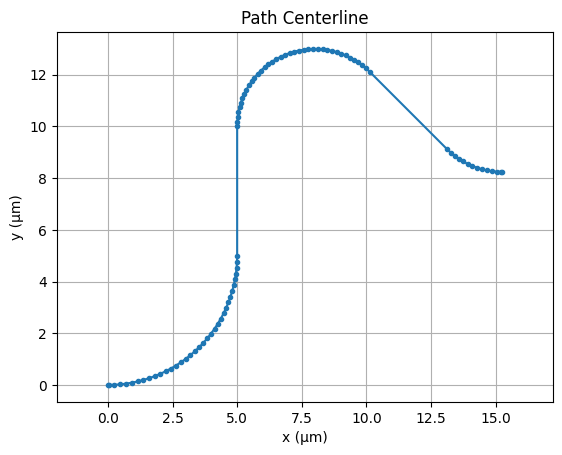

In [7]:
# Get the centerline coordinates
center = p.center()
x, y = zip(*center)  # Unpack into x and y lists

# Plot the centerline
plt.plot(x, y, marker=".")  # Plot points with markers
plt.axis("equal")  # Equal aspect ratio for x and y
plt.title("Path Centerline")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.grid()
plt.show()

### Accessing and Modifying Path Properties

Paths expose several geometric properties such as `x_min`, `x_mid`, `x_max`, `y_min`, `y_mid`, `y_max`, `size`, `area`, `origin`, and `bounds()`. These can be useful for alignment, placement, and inspection. Some of these properties are also settable; for example, we can shift the entire path vertically by updating `y_min`. The path length is another important property which can be calculated using `length()` method.


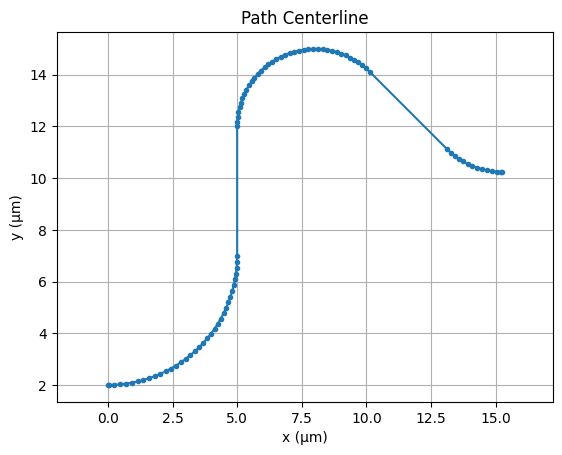

In [8]:
# Shift the path vertically
p.y_min += 2

# Get the centerline coordinates
center = p.center()
x, y = zip(*center)  # Unpack into x and y lists

# Plot the centerline
plt.plot(x, y, marker=".")  # Plot points with markers
plt.axis("equal")  # Equal aspect ratio for x and y
plt.title("Path Centerline")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.grid()
plt.show()

You can also check the length of the curve with the `length()` method:

In [9]:
# Print length of the path
print(p.length())

26.51931330563207


## Component Creation

Now that you've got your path defined, the next step is to generate a Component. Then you can create 3D structures based on the extrusion specs of the default technology.

### Option 1: Single layer and width cross section

The simplest option is to define a constant-width cross section and add it to a layer (e.g. the 220 nm "WG_CORE" layer) using the `add` method.


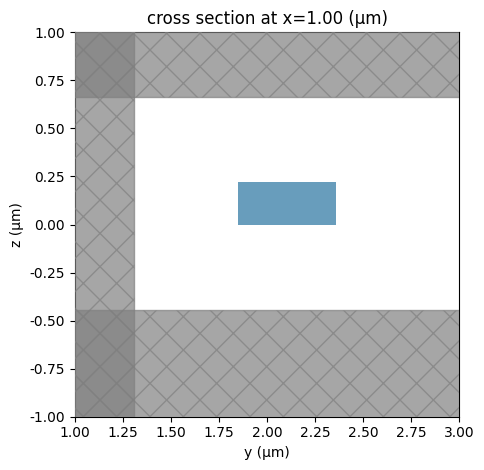

In [10]:
# Create a new Component
c = pf.Component()

# Add the path to the "WG_CORE" layer with default extrusion specs
c.add("WG_CORE", p)

# Visualize the cross section of the 3D structure using the default Tidy3D plot settings
pf.tidy3d_plot(c, x=1, vlim=(-1, 1), hlim=(1, 3))

# Display the component layout
c

### Option 2: Multi-Layer Custom Cross Section

You can also define an arbitrary cross section by stacking multiple paths on different layers. This allows you to model structures like a "Rib" waveguide. In this example, we create a narrow core on the "WG_CORE" layer and a wider slab on the "SLAB" layer.


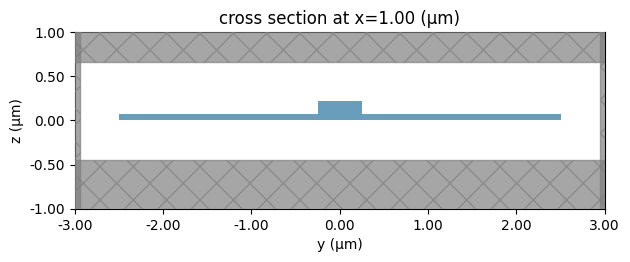

In [11]:
# Create the core waveguide path
p1 = pf.Path((0, 0), width=0.5).segment((5, 0))

# Create the slab path
p2 = pf.Path((0, 0), width=5).segment((5, 0))

# Create a new Component
c = pf.Component()

# Add the paths to different layers: core on "WG_CORE", slab on "SLAB"
c.add("WG_CORE", p1, "SLAB", p2)

# Visualize the cross section of the resulting 3D structure
pf.tidy3d_plot(c, x=1, vlim=(-1, 1), hlim=(-3, 3))

# Display the component layout
c

You can also assign an `offset` to the path. Let's apply an `offset` to the slab path in the previous example.

In [12]:
# Create the waveguide path with offset
p1 = pf.Path((0, 0), width=0.5, offset=3).segment((5, 0))

# Create a new Component
c = pf.Component()

# Add the paths to different layers: core on "WG_CORE", slab on "SLAB"
c.add("WG_CORE", p1, "SLAB", p2)

The **offset** of a path can vary along its length. You can define the offset change using a constant value, a smooth transition, or a custom expression. In this example, the offset varies linearly from 3 to 4 along the segment.


In [13]:
# Create a path with width 0.5 and varying offset
p1 = pf.Path((0, 0), width=0.5).segment((5, 0), offset=(3, 4, "linear"))

# Create a new Component
c = pf.Component()

# Add the paths to different layers: core on "WG_CORE", slab on "SLAB"
c.add("WG_CORE", p1, "SLAB", p2)

### Option 3: Tapered Cross Section

You can create tapered waveguides by specifying a varying width along the segment. By default, the interpolation is linear, but you can also choose `"smooth"` for a gradual transition using a third-degree polynomial with zero derivatives at both ends. Additionally, you can modify the starting width if needed.


In [14]:
# Create a tapered path from width 0.5 to 1 using smooth interpolation
p = pf.Path((0, 0), width=0.5).segment((3, 0), width=(1, "smooth"))

# Create a new Component
c = pf.Component()

# Add the tapered path to the "WG_CORE" layer
c.add("WG_CORE", p)

**Tapering Along a Curved Path**

Tapering is not limited to straight segments—it can also be applied along curves. In this example, we create a 90° turn and taper the width smoothly from 0.5 to 1 along the arc.


In [15]:
p = pf.Path((0, 0), width=0.5).turn(90, radius=5, width=(1, "smooth"))

# Create a new Component
c = pf.Component()

# Add the tapered path to the "WG_CORE" layer
c.add("WG_CORE", p)

For full control over the taper profile, you can define a custom width using an expression pair: `(value_expression, derivative_expression)`. These are evaluated along the segment using the variable `u`, which ranges from 0 to 1 along the path. This allows for arbitrary taper shapes and smoothness. Refer to the documentation on [Expression](../_autosummary/photonforge.Expression.rst#photonforge.Expression) for supported syntax and operators.


In [16]:
# Create a path with width defined by a custom expression
p = pf.Path((0, 0), width=0.5).segment((3, 0), ("0.5 + 0.5 * u^2", "u"))

# Create a new Component
c = pf.Component()

# Add the custom-tapered path to the "WG_CORE" layer
c.add("WG_CORE", p)

### Option 4: Cross Section with Custom Width Profile

This approach is useful in many photonic devices for designing **adiabatic tapers**. Here, we define a width profile using cubic spline interpolation and apply it segment-by-segment along the path. This allows for a smooth and highly customized transition of waveguide width.


In [17]:
from scipy.interpolate import make_interp_spline

# Define control widths and total taper length
width_ctrl = [0.5, 0.6, 0.9, 1.2, 0.5]
length = 3

# Create a smooth spline curve from the control points
x_ctrl = np.linspace(0, length, len(width_ctrl))
spline = make_interp_spline(x_ctrl, width_ctrl, k=3)

# Generate high-resolution points along the spline
x_dense = np.linspace(0, length, 100)
widths = spline(x_dense)

# Construct the path using the interpolated width profile
p = pf.Path((0, 0), width=widths[0])
for x, w in zip(x_dense[1:], widths[1:]):
    p.segment((x, 0), w)

# Create a component and add the path
c = pf.Component()
c.add("WG_CORE", p)

# Display the result
c

### Option 5: Putting Components Along the Path

In some applications, we may want to place a repeated structure—like electrodes or teeth—along a transmission line or waveguide path. Here we demonstrate how to define such a pattern using a zero-width path and a custom **`parametric`** section. We then design a simple "tooth" component and use the **`interpolate`** method to place copies of it periodically along the path, while aligning them with the local tangent direction. This is especially useful for building segmented coplanar waveguides (CPW), grating waveguides, or periodic electrodes/vias.


In [18]:
# Create a path with zero width, composed of segments and parametric curves
p = (
    pf.Path((0, 0), 0)  # Start with zero width
    .segment((50, 0))  # Straight segment to the right
    .s_bend((180, 20), euler_fraction=0.5)  # Smooth 180° turn
    .parametric(  # Add a parametric curve section
        ("80 * u", "-40 * u^2"),  # Parametric x(u), y(u)
        ("80", "-80 * u"),  # Derivative dx/du, dy/du
    )
)

# Display the constructed path
p

In [19]:
# Create a basic "tooth" structure using rectangles on the METAL layer
tooth = pf.Component("Tooth")

tooth.add(
    "METAL",
    pf.Rectangle((-0.5, -1.3), (0.5, -0.5)),  # Narrow vertical finger (bottom)
    pf.Rectangle((-3, -0.5), (3, -0.2)),  # Horizontal plate (bottom)
    pf.Rectangle((-0.5, 1.3), (0.5, 0.5)),  # Narrow vertical finger (top)
    pf.Rectangle((-3, 0.5), (3, 0.2)),  # Horizontal plate (top)
)

# Create a CPW tooth component by duplicating the base tooth above and below the CPW center
cpw_tooth = pf.Component("Cpw Tooth")
cpw_tooth.add_reference(tooth).translate((0, 3.05))  # Top electrode
cpw_tooth.add_reference(tooth).translate((0, -3.05))  # Bottom electrode

# Display the CPW tooth component
cpw_tooth

In [20]:
# Function to extrude a port profile along a path and place periodic components
def extrude(
    path: pf.Path, port_spec: pf.PortSpec, period: float = 0, reference=None
) -> pf.Component:
    c = pf.Component()  # Create a new component to hold the result

    # Add base paths to the appropriate layers
    for width, offset, layer in port_spec.path_profiles_list():
        c.add(layer, path.updated_copy(width, offset))

    # If a periodic component reference is provided, place it along the path
    if period > 0 and reference is not None:
        if isinstance(reference, pf.Component):
            reference = pf.Reference(reference)

        # Determine positions along the path and place aligned copies
        s = np.arange(period / 2, path.length(), period)
        for position, _, _, grad in zip(*path.interpolate(s)):
            rotation = np.arctan2(grad[1], grad[0]) * 180.0 / np.pi
            c.add(reference.copy().transform(position, rotation))

    return c

In [21]:
# Extrude the CPW line and place teeth periodically along the path
c = extrude(
    path=p,  # Path to follow
    port_spec=pf.config.default_technology.ports["CPW"],  # CPW port spec
    period=10,  # Periodic placement every 10 µm
    reference=cpw_tooth,  # Component to place along path
)

# Display the final component with path and teeth
viewer(c)

## Transitioning Between Ports

A common requirement in photonic layouts is transitioning between two different port types. The [parametric.transition()](../_autosummary/photonforge.parametric.transition.rst) function allows you to create a smooth taper between two `port_spec`s. You provide the start and end specifications, the length of the transition, and optionally a profile function (otherwise it uses linear transition) to control the taper shape. Below, we use a smooth cubic profile to transition from a strip to a rib waveguide.


In [22]:
# Create a component to hold the transition structure
c = pf.Component("Transition")

# Add a smooth taper transitioning from a strip to a rib waveguide
transition = c.add_reference(
    pf.parametric.transition(
        port_spec1="Strip",  # Starting port specification
        port_spec2="Rib",  # Ending port specification
        length=10,  # Total length of the transition
        profile="3*u^2-2*u^3",  # Cubic profile for smooth tapering
        constant_length=0.5,  # Add constant-width regions at both ends
    )
)

# Display the component
c

## Creating a Route Through Waypoints

We can use the [route()](../_autosummary/photonforge.parametric.route.rst) function to connect two ports while guiding the path through specific waypoints. Here, we define two custom ports and specify a series of waypoints to force the route to bend around obstacles or follow a desired path. We set a bending radius and use smooth Euler curves for both bends and S-bends.


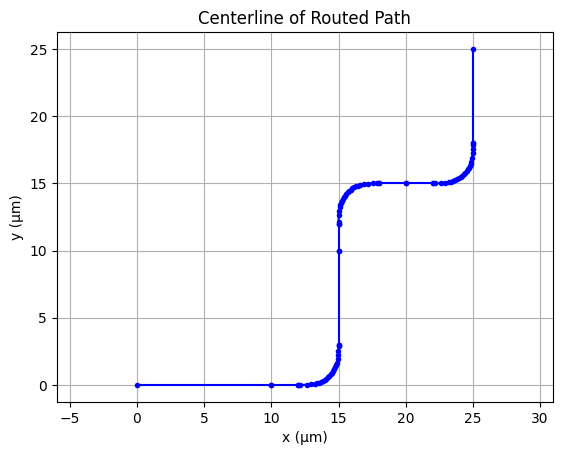

In [23]:
# Define two standalone ports (no parent component needed for routing)
port_a = pf.Port((0, 0), 180, "Strip")  # Port at (0, 0) pointing along +x
port_b = pf.Port((25, 25), 90, "Strip")  # Port at (25, 25) pointing along +y

# Create a routed component using intermediate waypoints
route_example = pf.parametric.route(
    port1=port_a,  # Starting port
    port2=port_b,  # Ending port
    radius=3,  # Bend radius
    bend_kwargs={"euler_fraction": 0.5},  # Use smooth Euler curves for bends
    s_bend_kwargs={"euler_fraction": 0.5},  # Use smooth Euler curves for S-bends
    waypoints=[  # Waypoints to guide the route
        (10, 0, 0),  # First waypoint at (10, 0), angle 0° (east)
        (15, 10, 90),  # Next at (15, 10), angle 90° (north)
        (20, 15, 0),  # Then at (20, 15), angle 0° (east)
    ],
    name="RouteExample",  # Name of the resulting component
)

# Extract the list of Path objects from the "WG_CORE" layer of the route
paths = route_example.get_structures("WG_CORE")

# Plot the combined centerline
for path in paths:
    center = path.center()  # Get centerline points
    x, y = zip(*center)  # Unpack to x and y
    plt.plot(x, y, marker=".", color="blue")  # Plot path segment

plt.axis("equal")  # Keep aspect ratio uniform
plt.title("Centerline of Routed Path")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.grid()
plt.show()

# Display the routed component
viewer(route_example)

### Adding a Bulge to Straight Segments
PhotonForge allows you to apply a **bulge** to straight segments in a routed path. This can be used to locally widen sections of the waveguide. The `bulge_width` sets the maximum width, `bulge_taper_length` controls how gradually the width transitions, and `bulge_margin` adjusts spacing around the bulge region.


In [24]:
route_example.update(
    straight_kwargs={"bulge_width": 0.6, "bulge_taper_length": 2, "bulge_margin": 0}
)

## Cladding Around a Path

We create a path with two turns and then compute its offset boundary using `offset()`. We enable `round_joins` to round the corners. Finally, we add the offset polygons to the **SLAB** layer and the original path to the **WG_CORE** layer.


In [25]:
# Create a path
p = (
    pf.Path((0, 0), width=0.5)  # Start at origin with width 0.5
    .turn(45, radius=3)  # Turn 45° clockwise with radius 3
    .segment((3, 3), relative=True)  # Move diagonally from current position
    .turn(-45, radius=3)  # Turn 45° counter-clockwise with radius 3
    .segment((5, 0), relative=True)  # Move horizontally to the right
)

# Compute offset polygons around the path with distance 0.5 and rounded joins
env_polygons = pf.offset(p, distance=0.5, round_joins=True)

# Create a component to hold the path and its offset boundary
c = pf.Component()

# Add each offset polygon to the "SLAB" layer
c.add("SLAB", *env_polygons)

# Add the original path to the "WG_CORE" layer
c.add("WG_CORE", p)

# Display the component with offset boundary and path
c